### thibauts reshaping problem

In [18]:
import numpy as np

def show_images(*img_list, clip_pct=None, titles=None, save_str=False, n_cols=3, axes=False, cmap="viridis",
                labels=None,
                dpi=None, timer_flag=None,colorbar=True):
    """Designed to plot torch tensor and numpy arrays in windows robustly"""

    if labels is None:
        labels = []
    if titles is None:
        titles = []
    if dpi:
        mpl.rcParams['figure.dpi'] = dpi

    img_list = [img for img in img_list]
    if isinstance(img_list[0], list):
        img_list = img_list[0]

    rows = (len(img_list) - 1) // n_cols + 1
    columns = np.min([n_cols, len(img_list)])
    fig = plt.figure(figsize=(5 * (columns + 1), 5 * (rows + 1)))

    fig.tight_layout()
    grid = plt.GridSpec(rows, columns, figure=fig)
    grid.update(wspace=0.2, hspace=0, left=None, right=None, bottom=None, top=None)

    for i, img in enumerate(img_list):

        if torch.is_tensor(img):
            img = torch.squeeze(img).detach().cpu().numpy()
        img = np.squeeze(img)
        if len(img.shape) > 2:
            img = np.moveaxis(img, np.argmin(img.shape), -1)
            if img.shape[-1] > 4 or img.shape[-1] == 2:
                plt.close()
                show_images([img[..., i] for i in range(img.shape[-1])], clip_pct=clip_pct,
                            titles=["Channel:" + str(i) for i in range(img.shape[-1])], save_str=save_str,
                            n_cols=n_cols, axes=axes, cmap=cmap,colorbar=colorbar)
                continue
        ax1 = plt.subplot(grid[i])
        if not axes:
            plt.axis('off')
        if clip_pct is not None:
            print(np.percentile(img.ravel(), clip_pct), np.percentile(img.ravel(), 100 - clip_pct))
            im = ax1.imshow(img, vmin=np.percentile(img.ravel(), clip_pct),
                            vmax=np.percentile(img.ravel(), 100 - clip_pct))
        if i in labels:
            img = img.astype(int)
            img = fastremap.renumber(img)[0]
            n_instances = len(fastremap.unique(img))
            glasbey_cmap = cc.cm.glasbey_bw_minc_20_minl_30_r.colors
            glasbey_cmap[0] = [0, 0, 0]  # Set bg to black
            cmap_lab = LinearSegmentedColormap.from_list('my_list', glasbey_cmap, N=n_instances)
            im = ax1.imshow(img, cmap=cmap_lab, interpolation='nearest')
        else:
            im = ax1.imshow(img, cmap=cmap)
        if colorbar:
            plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
        if i<len(titles):
            ax1.set_title(titles[i])
    if not save_str:

        if timer_flag is not None:
            plt.show(block=False)
            plt.pause(timer_flag)
            plt.close()
        plt.show()

    if save_str:
        plt.savefig(str(save_str) + ".png", bbox_inches='tight')
        plt.close()
        return None

torch.Size([10, 2, 256, 256])
torch.Size([2, 256, 256]) torch.Size([5, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([5, 4, 256, 256])
torch.Size([327680, 4])


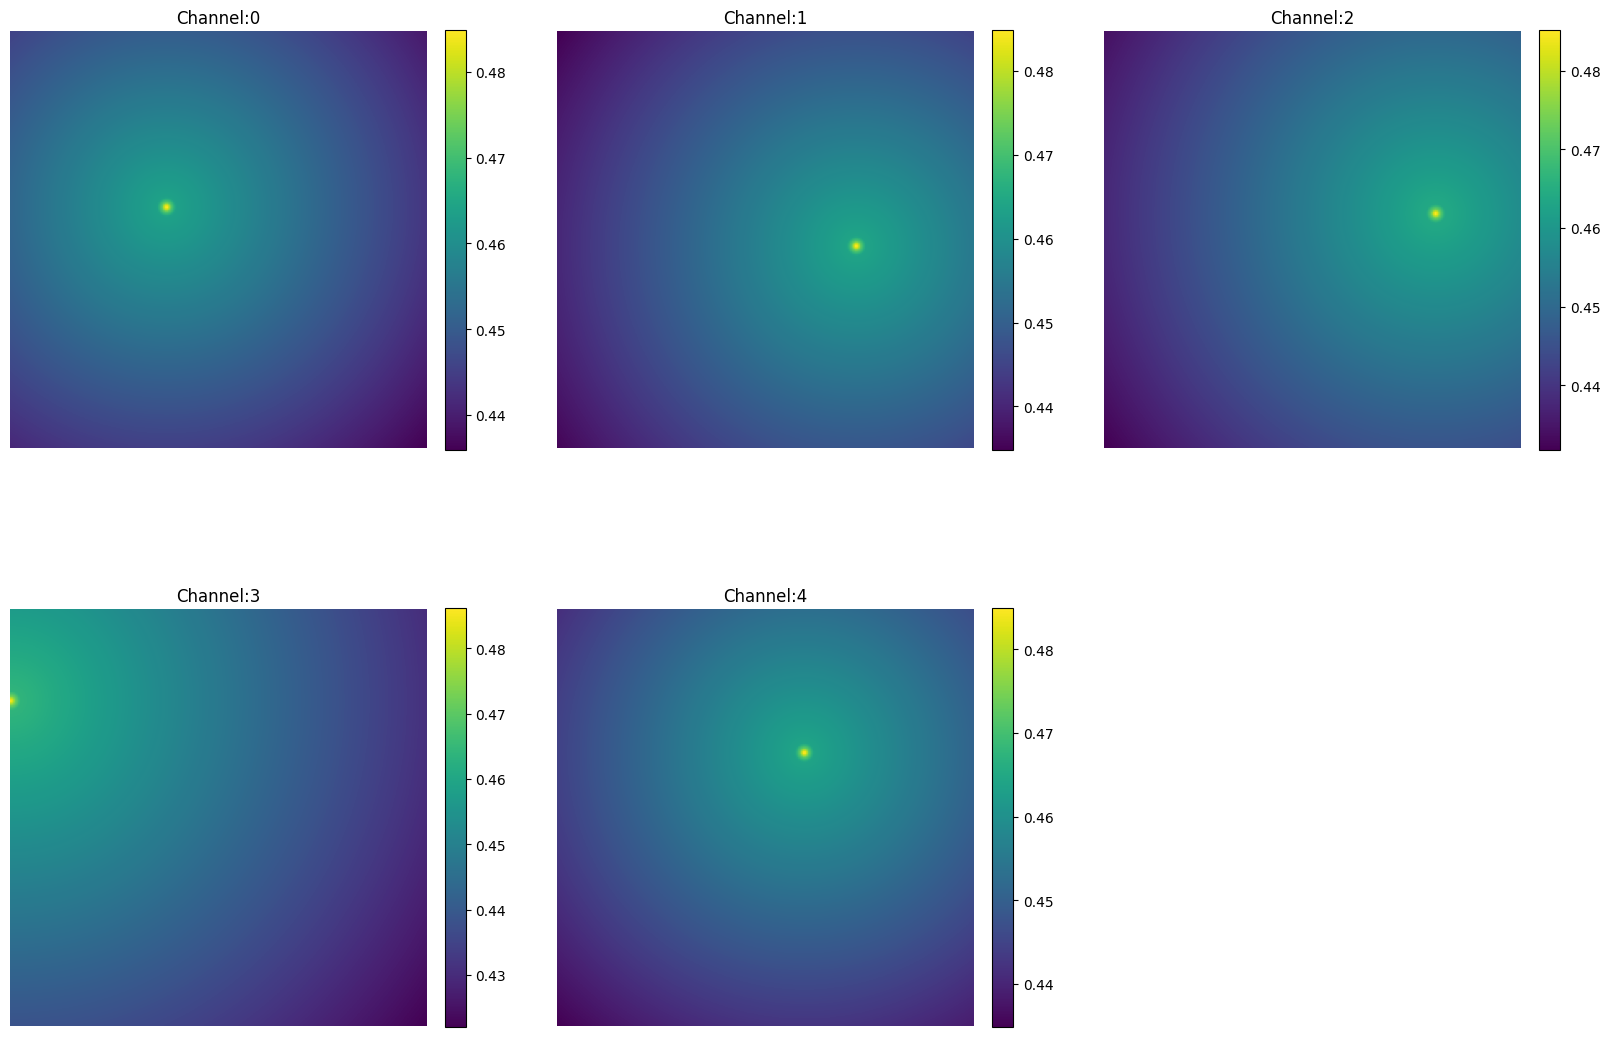

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# add norm as an extra channel
# keep sigmas, don't norm them

# shape of [centers, embedding dims, pixels]
# we want [centers, 1, H, W] output


# class ProbabilityNet(nn.Module):
#     def __init__(self):
#         super(ProbabilityNet, self).__init__()
#         self.fc1 = nn.Linear(2, 10)
#         self.fc2 = nn.Linear(10, 1)

#     def forward(self, x, c, sigma):
#         """
#         x: input tensor of shape (E,H,W)
#         c: center (C,2)
#         sigma: sigma (S,H,W)
#         """
#         b = x.shape[0]
#         h, w = x.shape[-2:]
#         C = c.shape[0]

#         N = sigma.shape[0] + b

#         # Concatenate along the first dimension (E) to create (E+S,H,W)
#         x = torch.cat((x, sigma))

#         # Repeat centers to match the number of elements in x
#         c = torch.cat((c, torch.zeros_like(c)[:,:sigma.shape[0]]), dim=1)

#         x = torch.sqrt(torch.sum(torch.pow(x - c.reshape(-1, N, 1, 1), 2),dim=1,keepdim=True))
        
#         x = torch.cat([x, x])
#         x = torch.cat([x,x], dim=1)
#         print(x.shape)

#         x = x.flatten(2)

#         x = [torch.relu(self.fc1(i.movedim(0,1))) for i in x] 

#         output = [torch.sigmoid(self.fc2(i)) for i in x]  # Softmax for PDF

#         output = torch.stack([i.view(1,h,w) for i in output], dim=0)

#         return output

    
class ProbabilityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x, c, sigma):
        """
        x: input tensor of shape (E,H,W)
        c: center (C,2)
        sigma: sigma (S,H,W)
        """
        b = x.shape[0]
        h, w = x.shape[-2:]
        C = c.shape[0]

        N = sigma.shape[0] + b

        norm = torch.sqrt(torch.sum(torch.pow(x - c.reshape(-1, b, 1, 1), 2),dim=1,keepdim=True))
        
        print(x.shape, norm.shape, sigma.shape)
        
        x = torch.cat([x, sigma], dim=0)
        x = x.expand(c.shape[0], *x.shape)
        
        x = x * 0
        x = torch.cat([x, norm], dim=1)
        print(x.shape)

        x = x.flatten(2).permute(0, -1, 1)
        x = x.reshape((x.shape[0] * x.shape[1]), x.shape[2])
        print(x.shape)

        x = torch.relu(self.fc1(x))

        output = torch.sigmoid(self.fc2(x))
        
        output = output.reshape(5, 1, h,w)

        # output = torch.stack([i.view(1,h,w) for i in output], dim=0)

        return output

spatial_dims = (256, 256)
embedding_dim = 2
xm = torch.linspace(0, 64, spatial_dims[1]).view(

    1, 1, -1).expand(1, *spatial_dims)

ym = torch.linspace(0, 64, spatial_dims[0]).view(

    1, -1, 1).expand(1, *spatial_dims)

x = torch.cat((xm, ym), 0)
# embedding_dim=3
# x=torch.randn(embedding_dim,*spatial_dims)

c=torch.randint(64,(5,embedding_dim)).float()

sigma=torch.randn(1,*spatial_dims) * 10

probability_net = ProbabilityNet()
probability_net2 = ProbabilityNet2()

with torch.no_grad():
    out = probability_net(x,c,sigma).cpu()
    out2 = probability_net2(x,c,sigma).cpu()

show_images(out2)

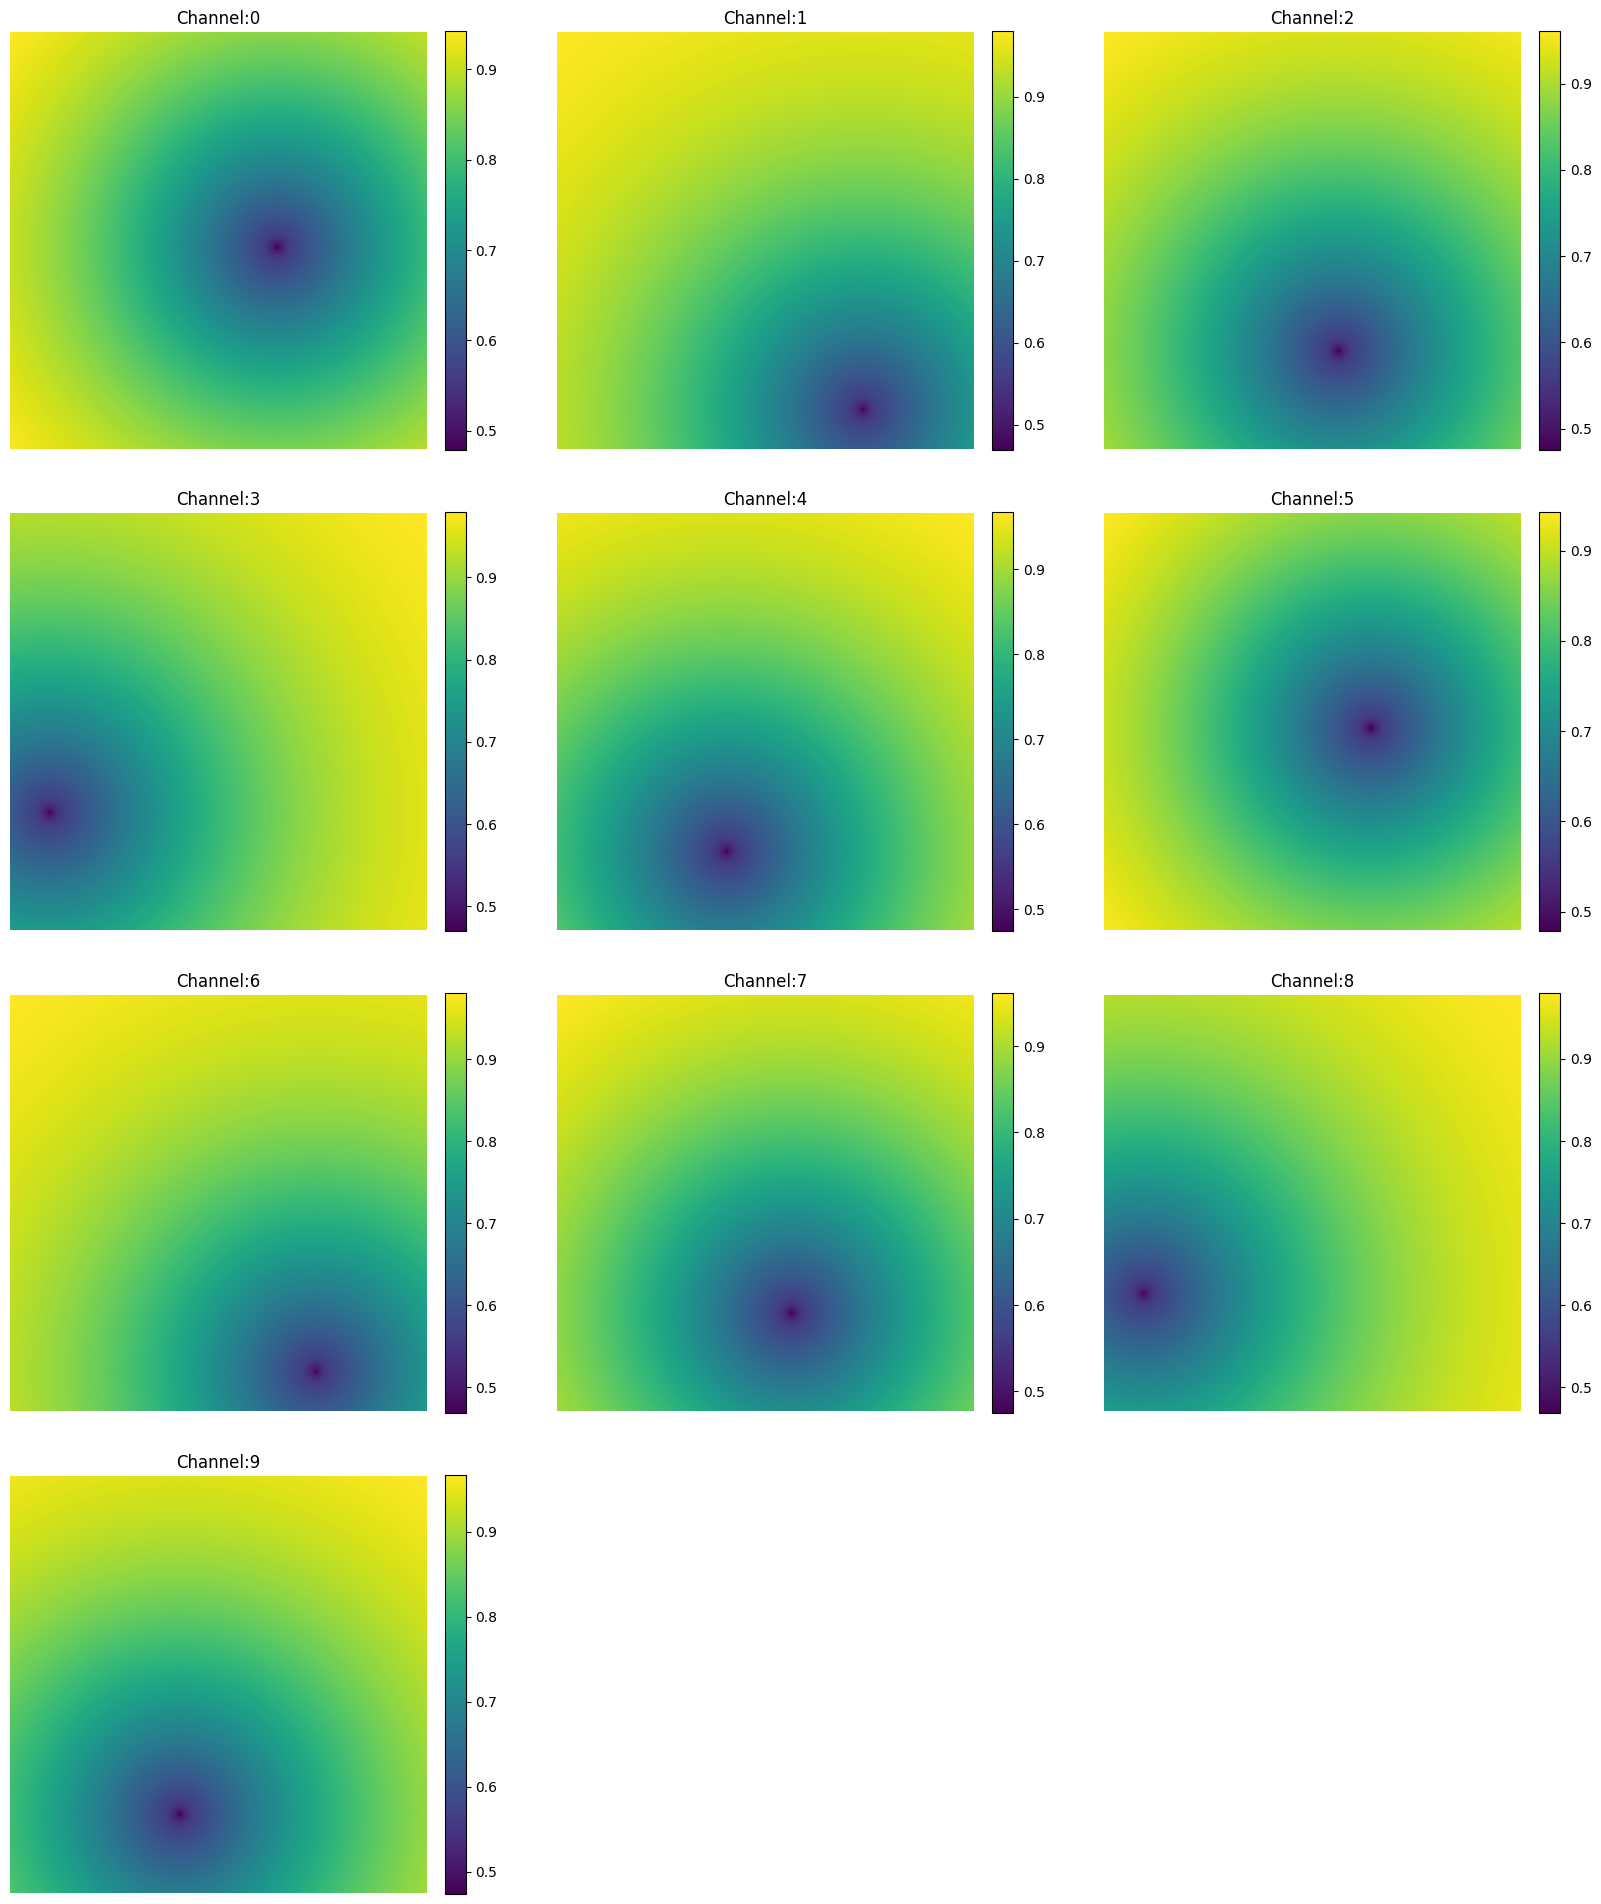

In [57]:
show_images(out)